## Cryptocurrency trading bot testing file.

### Install if needed.

In [1]:
##%pip install python-binance==0.7.5
#%pip install python-binance

### Examples loading directly from files.

In [2]:
import pandas as pd
crypto_exchange_info = 'crypto_logs/crypto_exchange_info.txt'
exchange_info = pd.read_csv(crypto_exchange_info, header=0, index_col=0)
exchange_info

,symbol,base_asset,base_asset_precision,quote_asset,quote_precision,quote_asset_precision,base_asset_commission,quote_commission_precision,allow_trailing_stop,cancel_replace_allowed,defaultSelfTradePreventionMode,allowedSelfTradePreventionModes,min_price,max_price,tick_size,step_size,multiplier_up
0,ETHBTC,ETH,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,922327.0,1.000000e-06,0.0001,5.0
1,LTCBTC,LTC,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0010,5.0
2,BNBBTC,BNB,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0010,5.0
3,NEOBTC,NEO,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0100,5.0
4,QTUMETH,QTUM,8,ETH,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,1000.0,1.000000e-06,0.1000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,HOOKBNB,HOOK,8,BNB,8,8,8,8,True,True,NONE,['NONE'],1.000000e-07,100.0,1.000000e-07,0.1000,5.0
1411,MAGICBTC,MAGIC,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-08,1000.0,1.000000e-08,0.1000,5.0
1412,MAGICBUSD,MAGIC,8,BUSD,8,8,8,8,True,True,NONE,['NONE'],1.000000e-04,1000.0,1.000000e-04,0.1000,5.0
1413,MAGICUSDT,MAGIC,8,USDT,8,8,8,8,True,True,NONE,['NONE'],1.000000e-04,1000.0,1.000000e-04,0.1000,5.0


In [3]:
#import pandas as pd
#crypto_output_log_15s = 'crypto_logs/crypto_input_log_15s.txt'
#conversion_table = pd.read_csv(crypto_output_log_15s, header=[0], index_col=0)
#conversion_table.index = pd.DatetimeIndex(conversion_table.index)
#conversion_table

In [4]:
import pandas as pd
crypto_output_log_15s = 'crypto_logs/crypto_output_log_15s.txt'
df_15s = pd.read_csv(crypto_output_log_15s, header=[0, 1], index_col=0)
df_15s.index = pd.DatetimeIndex(df_15s.index)
df_15s

symbol,BLZETH,BUSDRON,ENJGBP,FIOBUSD,LTOBTC,OOKIBUSD,POLSBUSD,STMXETH,USDTNGN,WINBNB,...,BLZETH,BUSDRON,ENJGBP,FIOBUSD,LTOBTC,OOKIBUSD,POLSBUSD,STMXETH,USDTNGN,WINBNB
pair,open,open,open,open,open,open,open,open,open,open,...,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume
date,,,,,,,,,,,,,,,,,,,,,
2022-12-20 01:31:15,0.000044,4.677,0.205,0.0271,0.000004,0.00292,0.342,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,38432.0529,4.937043,149230.61315,78128.3522,5.20631,1.304068e+08,82.018524
2022-12-20 01:31:30,0.000044,4.677,0.205,0.0271,0.000004,0.00292,0.342,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,38432.0529,4.937043,149230.61315,78128.3522,5.20631,1.304068e+08,82.018524
2022-12-20 01:31:45,0.000044,4.677,0.205,0.0271,0.000004,0.00292,0.342,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,38432.0529,4.937043,149230.61315,78128.3522,5.20631,1.304068e+08,82.018524
2022-12-20 01:32:00,0.000044,4.677,0.205,0.0273,0.000004,0.00292,0.343,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,40245.6465,4.941186,149647.79939,78456.6227,5.20631,1.304068e+08,82.018524
2022-12-20 01:32:15,0.000044,4.677,0.205,0.0273,0.000004,0.00292,0.343,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,40245.6465,4.941186,149647.79939,78456.6227,5.20631,1.304068e+08,82.018524
2022-12-20 01:32:30,0.000044,4.677,0.205,0.0273,0.000004,0.00292,0.343,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,40245.6465,4.941186,149647.79939,78456.6227,5.20631,1.304068e+08,82.018524
2022-12-20 01:32:45,0.000044,4.677,0.205,0.0273,0.000004,0.00292,0.343,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,40245.6465,4.941186,149647.79939,78456.6227,5.20631,1.304068e+08,82.018524
2022-12-20 01:33:00,0.000044,4.677,0.205,0.0273,0.000004,0.00292,0.344,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,40245.6465,4.941186,149647.79939,78456.6227,5.20631,1.304068e+08,82.018524


### Load from logged files.

In [5]:
from crypto_logger import init_loggers
crypto_loggers = init_loggers()
crypto_loggers

{'input_15s': <cryptocurrency.crypto_logger_input.Crypto_logger_input at 0x7f296ccddba0>,
 'output_15s': <cryptocurrency.crypto_logger_output.Crypto_logger_output at 0x7f296ccdd990>,
 'output_1min': <cryptocurrency.crypto_logger_output.Crypto_logger_output at 0x7f296671c370>,
 'output_1h': <cryptocurrency.crypto_logger_output.Crypto_logger_output at 0x7f296671c0a0>,
 'output_1d': <cryptocurrency.crypto_logger_output.Crypto_logger_output at 0x7f29626337c0>}

In [6]:
input_15s = crypto_loggers['input_15s']
output_15s = crypto_loggers['output_15s']
output_1min = crypto_loggers['output_1min']
#output_30min = crypto_loggers['output_30min']
output_1h = crypto_loggers['output_1h']
output_1d = crypto_loggers['output_1d']

In [7]:
df_input_15s = input_15s.maybe_get_from_file(dataset=None, inputs=False, screened=False)
df_input_15s

In [8]:
df_output_15s = output_15s.maybe_get_from_file(dataset=None, inputs=False, screened=False)
df_output_15s

symbol,BLZETH,BUSDRON,ENJGBP,FIOBUSD,LTOBTC,OOKIBUSD,POLSBUSD,STMXETH,USDTNGN,WINBNB,...,BLZETH,BUSDRON,ENJGBP,FIOBUSD,LTOBTC,OOKIBUSD,POLSBUSD,STMXETH,USDTNGN,WINBNB
pair,open,open,open,open,open,open,open,open,open,open,...,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume
date,,,,,,,,,,,,,,,,,,,,,
2022-12-20 01:31:15,0.000044,4.677,0.205,0.0271,0.000004,0.00292,0.342,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,38432.0529,4.937043,149230.61315,78128.3522,5.20631,1.304068e+08,82.018524
2022-12-20 01:31:30,0.000044,4.677,0.205,0.0271,0.000004,0.00292,0.342,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,38432.0529,4.937043,149230.61315,78128.3522,5.20631,1.304068e+08,82.018524
2022-12-20 01:31:45,0.000044,4.677,0.205,0.0271,0.000004,0.00292,0.342,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,38432.0529,4.937043,149230.61315,78128.3522,5.20631,1.304068e+08,82.018524
2022-12-20 01:32:00,0.000044,4.677,0.205,0.0273,0.000004,0.00292,0.343,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,40245.6465,4.941186,149647.79939,78456.6227,5.20631,1.304068e+08,82.018524
2022-12-20 01:32:15,0.000044,4.677,0.205,0.0273,0.000004,0.00292,0.343,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,40245.6465,4.941186,149647.79939,78456.6227,5.20631,1.304068e+08,82.018524
2022-12-20 01:32:30,0.000044,4.677,0.205,0.0273,0.000004,0.00292,0.343,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,40245.6465,4.941186,149647.79939,78456.6227,5.20631,1.304068e+08,82.018524
2022-12-20 01:32:45,0.000044,4.677,0.205,0.0273,0.000004,0.00292,0.343,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,40245.6465,4.941186,149647.79939,78456.6227,5.20631,1.304068e+08,82.018524
2022-12-20 01:33:00,0.000044,4.677,0.205,0.0273,0.000004,0.00292,0.344,0.000003,743.2,3.200000e-07,...,7.53503,369783.084,1034.28643,40245.6465,4.941186,149647.79939,78456.6227,5.20631,1.304068e+08,82.018524


In [9]:
df_output_1min = output_1min.maybe_get_from_file(dataset=None, inputs=False, screened=False)
df_output_1min

symbol,BLZETH,BUSDRON,ENJGBP,FIOBUSD,LTOBTC,OOKIBUSD,POLSBUSD,STMXETH,USDTNGN,WINBNB,...,BLZETH,BUSDRON,ENJGBP,FIOBUSD,LTOBTC,OOKIBUSD,POLSBUSD,STMXETH,USDTNGN,WINBNB
pair,open,open,open,open,open,open,open,open,open,open,...,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume
date,,,,,,,,,,,,,,,,,,,,,
2022-12-19 00:47:00,0.000045,4.682,0.2129,0.0288,0.000004,0.00308,0.356,0.000003,751.6,3.200000e-07,...,0.660089,202399.013,620.21004,219920.0583,2.510292,99054.58281,71308.7166,11.586934,1.012158e+08,104.619389
2022-12-19 00:48:00,0.000045,4.682,0.2129,0.0288,0.000004,0.00308,0.356,0.000003,752.0,3.200000e-07,...,0.660089,202399.013,620.21004,219920.0583,2.510292,99054.58281,71308.7166,11.586934,1.012158e+08,104.619389
2022-12-19 00:49:00,0.000045,4.682,0.2129,0.0288,0.000004,0.00308,0.356,0.000003,752.0,3.200000e-07,...,0.660089,202399.013,620.21004,219920.0583,2.510292,99459.65517,71308.7166,11.586934,1.012158e+08,104.619389
2022-12-19 00:50:00,0.000045,4.682,0.2129,0.0288,0.000004,0.00308,0.356,0.000003,752.0,3.200000e-07,...,0.660089,202399.013,620.21004,219920.0583,2.510292,99459.65517,71308.7166,11.586934,1.012158e+08,104.619389
2022-12-19 00:51:00,0.000045,4.682,0.2129,0.0288,0.000004,0.00308,0.356,0.000003,752.2,3.200000e-07,...,0.660089,202399.013,620.21004,219920.0583,2.510292,99459.65517,71308.7166,11.586934,1.012885e+08,104.619389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20 01:42:00,0.000044,4.677,0.2050,0.0274,0.000004,0.00292,0.344,0.000003,743.4,3.200000e-07,...,7.535030,369783.084,1034.28643,41772.2101,4.948291,147370.23872,78399.6452,5.206310,1.304263e+08,81.933947
2022-12-20 01:43:00,0.000044,4.677,0.2050,0.0274,0.000004,0.00292,0.344,0.000003,743.4,3.200000e-07,...,7.535030,369783.084,1034.28643,41772.2101,4.948291,147360.13632,78399.6452,5.206310,1.304263e+08,81.933947


In [10]:
#df_output_30min = output_30min.maybe_get_from_file(dataset=None, inputs=False, screened=False)
#df_output_30min

In [11]:
df_output_1h = output_1h.maybe_get_from_file(dataset=None, inputs=False, screened=False)
df_output_1h

In [12]:
df_output_1d = output_1d.maybe_get_from_file(dataset=None, inputs=False, screened=False)
df_output_1d

In [13]:
df_input_15s_screened = input_15s.maybe_get_from_file(dataset=None, inputs=False, screened=True)
df_input_15s_screened

In [14]:
df_output_15s_screened = output_15s.maybe_get_from_file(dataset=None, inputs=False, screened=True)
df_output_15s_screened

In [15]:
df_output_1min_screened = output_1min.maybe_get_from_file(dataset=None, inputs=False, screened=True)
df_output_1min_screened

In [16]:
#df_output_30min_screened = output_30min.maybe_get_from_file(dataset=None, inputs=False, screened=True)
#df_output_30min_screened

In [17]:
df_output_1h_screened = output_1h.maybe_get_from_file(dataset=None, inputs=False, screened=True)
df_output_1h_screened

In [18]:
df_output_1d_screened = output_1d.maybe_get_from_file(dataset=None, inputs=False, screened=True)
df_output_1d_screened

### Uncomment to start logger.

In [19]:
#from crypto_logger import loop_loggers
#loop_loggers(crypto_loggers)

### Test indicators individually.

In [20]:
import pandas_ta as ta

def filter_in_market(function, dataset):
    def f(x):
        x = x.loc[:,~x.columns.duplicated()]
        return function(x)
    tickers_list = dataset.columns.get_level_values(0).unique().tolist()
    return pd.Series([ticker for ticker in tickers_list if f(dataset[ticker])], dtype='str')

def get_relative_volume_levels_smoothed_trigger(data, average1=26, average2=14, threshold=0.2):
    volume = data['volume']
    volume_average = ta.sma(close=volume, length=average1)
    relative_volume = volume / volume_average
    smoothed_relative_volume = ta.sma(close=relative_volume, length=average2)
    return (smoothed_relative_volume > threshold).iat[-1]

def get_relative_volume_levels_at_time_smoothed_thresholded(data):
    try:
        volume = data['volume']
        #volume = volume.groupby(pd.Grouper(freq='D')).cumsum()
        cum_volume = volume.groupby(pd.Grouper(freq='24h')).cumsum()
        #volume = volume.groupby(pd.Grouper(freq='60m')).cumsum()
        cum_rvol = (cum_volume / cum_volume.shift(1)).fillna(method='pad')
        rvol = (volume / volume.shift(1)).fillna(method='pad')
        bar_up = (data['close'] > data['open'])
        bar_up |= (data['close'] == data['open']) & (data['close'].diff() > 0)
        bar_up = bar_up.astype(int)
        bar_up = bar_up * 2 - 1
        #rvol *= bar_up
        cum_rvol_dir = cum_rvol * bar_up
        rvol_dir = rvol * bar_up
        rvol_indicator = ta.hma(rvol, length=14, talib=True)
        rvol_dir_indicator = ta.hma(rvol_dir, length=14, talib=True)
        cum_rvol_indicator = ta.hma(cum_rvol, length=14, talib=True)
        cum_rvol_dir_indicator = ta.hma(cum_rvol_dir, length=14, talib=True)
        rvol_indicator = rvol_indicator.rename('relative_volume_levels_smoothed')
        rvol_dir_indicator = rvol_dir_indicator.rename('relative_volume_levels_dir_smoothed')
        cum_rvol_indicator = cum_rvol_indicator.rename('cum_relative_volume_levels_smoothed')
        cum_rvol_dir_indicator = cum_rvol_dir_indicator.rename('cum_relative_volume_levels_dir_smoothed')
        #threshold = (ta.sma(rvol, length=100, talib=True) + ta.stdev(rvol, length=100, talib=True))
        threshold_dir = 0
        threshold = 2
        rvol_thresholded = (rvol_indicator > threshold).iat[-1]
        rvol_dir_thresholded = (rvol_dir_indicator > threshold_dir).iat[-1]
        cum_rvol_thresholded = (cum_rvol_indicator > threshold).iat[-1]
        cum_rvol_dir_thresholded = (cum_rvol_dir_indicator > threshold_dir).iat[-1]
        trigger = (rvol_thresholded | rvol_dir_thresholded | cum_rvol_thresholded | cum_rvol_dir_thresholded)
    except Exception as e:
        print('rvol exception:', e)
        trigger = False
    return trigger

def get_positive_trend_strength_trigger(data):
    ADX = data.ta.adx(talib=True)
    return (ADX['ADX_14'] < 0.20).iloc[-3] & (ADX['ADX_14'] > 0.20).iat[-2]

def get_not_negative_trend_strength_trigger(data):
    ADX = data.ta.adx(length=14, lensig=8, talib=True)
    return ((ADX['DMP_14'] > ADX['DMN_14']) & (ADX['ADX_14'] > 0.30)).iat[-1]

def get_not_negative_rebound_trigger(data):
    CCI = data.ta.cci(length=22, talib=True)
    MFI = data.ta.mfi(length=11, talib=True)
    return ((CCI > 0) | (MFI > 20)).iat[-1]

def get_positive_choppiness_trigger(data):
    CHOP = data.ta.chop(talib=True)
    return CHOP.iat[-1] < 38.2

def get_positive_phase_trigger(data):
    MACD = data.ta.macd(talib=True)
    histogram = MACD['MACDs_12_26_9'] - MACD['MACD_12_26_9']
    return ((histogram > histogram.shift(1)) | \
            (MACD['MACD_12_26_9'] > MACD['MACDs_12_26_9'])).iat[-1]

def get_positive_phase_trigger(data):
    MACD = data.ta.macd(talib=True)
    histogram = MACD['MACDs_12_26_9'] - MACD['MACD_12_26_9']
    return ((histogram.iloc[-2] > histogram.iat[-2]) or \
            (MACD['MACD_12_26_9'].iat[-1] > MACD['MACDs_12_26_9'].iat[-1]))

def get_not_square_wave_triggers(data, multiplier_schedule):
    triggers = True
    for multiplier in multiplier_schedule:
        period_1 = -4 * multiplier
        uniques_1 = 2 * multiplier
        square_wave_trigger_1 = (data.iloc[period_1:]['close'].unique().size < uniques_1)
        if square_wave_trigger_1:
            triggers = False
            break
        else:
            period_2 = -15 * multiplier
            uniques_2 = 6 * multiplier
            square_wave_trigger_2 = (data.iloc[period_2:]['close'].unique().size < uniques_2)
            if square_wave_trigger_2:
                triggers = False
                break
    return triggers

def get_minute_not_square_wave_triggers(data):
    return get_not_square_wave_triggers(data, multiplier_schedule=[1, 2, 3, 5, 10, 15, 20, 45])

def get_hourly_not_square_wave_triggers(data):
    return get_not_square_wave_triggers(data, multiplier_schedule=[1])

def get_daily_not_square_wave_triggers(data):
    return get_not_square_wave_triggers(data, multiplier_schedule=[1])

def get_daily_volume_minimum_trigger(data):
    return (data['volume'] > 1000000).iat[-1]

def get_daily_volume_change_trigger(data):
    return ((data['volume'].pct_change(1) * 100) > 300).iat[-1]

def get_minute_daily_volume_minimum_trigger(data):
    return (data['rolling_base_volume'] > 1000000).iat[-1]

def get_minute_daily_volume_change_trigger(data):
    return ((data['rolling_base_volume'].pct_change(1440) * 100) > 300).iat[-1]

def get_rising_volume_trigger(data):
    return (data['rolling_base_volume'].diff(1) > 0).iat[-1]

In [21]:
if df_output_1d is not None:
    df = df_output_1d.copy()
    df.columns = df.columns.swaplevel(0, 1)
    df = df.rename(columns={'base_volume': 'volume'})
    df.columns = df.columns.swaplevel(0, 1)
    filtered_1 = set(filter_in_market(get_daily_not_square_wave_triggers, df).tolist())
    filtered_2 = set(filter_in_market(get_daily_volume_minimum_trigger, df).tolist())
    filtered_3 = set(filter_in_market(get_relative_volume_levels_smoothed_trigger, df).tolist())
    filtered_1d = pd.Series(list(filtered_1 & filtered_2 & filtered_3))
    filtered_1d

In [22]:
if df_output_1h is not None:
    df = df_output_1h.copy()
    df.columns = df.columns.swaplevel(0, 1)
    df = df.rename(columns={'base_volume': 'volume'})
    df.columns = df.columns.swaplevel(0, 1)
    filtered_1 = set(filter_in_market(get_hourly_not_square_wave_triggers, df).tolist())
    filtered_2 = set(filter_in_market(get_relative_volume_levels_at_time_smoothed_thresholded, df).tolist())
    filtered_1h = pd.Series(list(filtered_1 & filtered_2))
    filtered_1h

In [23]:
from cryptocurrency.indicators import filter_in_market, screen_one
if df_output_1min is not None:
    df = df_output_1min.copy()
    df.columns = df.columns.swaplevel(0, 1)
    df = df.rename(columns={'base_volume': 'volume'})
    df.columns = df.columns.swaplevel(0, 1)
    filtered = filter_in_market(screen_one, df).tolist()
    filtered

In [24]:
if df_output_1min is not None:
    df = df_output_1min.copy()
    df.columns = df.columns.swaplevel(0, 1)
    df = df.rename(columns={'base_volume': 'volume'})
    df.columns = df.columns.swaplevel(0, 1)
    filtered_1 = set(filter_in_market(get_minute_not_square_wave_triggers, df).tolist())
    filtered_2 = set(filter_in_market(get_minute_daily_volume_minimum_trigger, df).tolist())
    filtered_3 = set(filter_in_market(get_minute_daily_volume_change_trigger, df).tolist())
    filtered_4 = set(filter_in_market(get_rising_volume_trigger, df).tolist())
    filtered_1min = pd.Series(list(filtered_1 & filtered_2 & filtered_3 & filtered_4))
    filtered_1min

/tmp/ipykernel_14757/3527216426.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filtered_1min = pd.Series(list(filtered_1 & filtered_2 & filtered_3 & filtered_4))


In [25]:
try:
    print(list(set(filtered_1h.tolist()) & set(filtered_1d.tolist())))
except NameError:
    pass

In [26]:
try:
    print(list(set(filtered_1min.tolist()) & set(filtered_1h.tolist())))
except NameError:
    pass

In [27]:
try:
    print(list(set(filtered_1min.tolist()) & set(filtered_1d.tolist())))
except NameError:
    pass

In [28]:
try:
    print(list(set(filtered_1min.tolist()) & set(filtered_1h.tolist()) & set(filtered_1d.tolist())))
except NameError:
    pass

### Conversion tests.

#### Example testing conversion_table directly (a bottleneck).

In [29]:
# Time initialization from here.
import time
t1 = time.time()

# Import libraries.
from cryptocurrency.authentication import Cryptocurrency_authenticator
from cryptocurrency.exchange import Cryptocurrency_exchange
from cryptocurrency.conversion import get_timezone_offset_in_seconds
from cryptocurrency.conversion_table import get_conversion_table

# Manage API keys.
authenticator = Cryptocurrency_authenticator(use_keys=False, testnet=False)
client = authenticator.spot_client

# Get all available pair information for trading.
exchange = Cryptocurrency_exchange(client=client, directory='crypto_logs')
exchange_info = exchange.info

# Precalculate UTC offset for inter-server communication coherence.
offset_s = get_timezone_offset_in_seconds()

# Precalculate conversion_table.
conversion_table = get_conversion_table(client=client, 
                                        exchange_info=exchange_info, 
                                        offset_s=offset_s, 
                                        dump_raw=False, 
                                        as_pair=True, 
                                        minimal=False, 
                                        extra_minimal=True, 
                                        super_extra_minimal=False, 
                                        convert_to_USDT=False)

# Print elapsed time from the beginning of the initialization until now.
t2 = time.time()
print('Elapsed time:', t2 - t1)

# Display pre-computed conversion table.
conversion_table.sort_values(by='rolling_base_volume', ascending=False).head(50)

Elapsed time: 2.6789588928222656


,symbol,base_asset,quote_asset,open,high,low,close,rolling_base_volume,rolling_quote_volume,count,bid_price,ask_price,bid_volume,ask_volume,price_change_percent,rolling_base_quote_volume,bid_ask_percent_change,bid_ask_volume_percent_change
date,,,,,,,,,,,,,,,,,,
2022-12-20 17:58:36.856,SHIBUSDT,SHIB,USDT,8.550000e-06,8.590000e-06,7.930000e-06,8.370000e-06,4.115292e+12,3.416352e+07,78718,8.360000e-06,8.370000e-06,6.864680e+09,2.746706e+09,-2.105,4.081663e+12,0.119474,71.422375
2022-12-20 17:58:34.638,SHIBBUSD,SHIB,BUSD,8.560000e-06,8.590000e-06,7.940000e-06,8.380000e-06,2.084355e+12,1.733164e+07,49712,8.370000e-06,8.380000e-06,9.325176e+08,4.925206e+09,-2.103,2.068215e+12,0.119332,15.919454
2022-12-20 17:58:37.260,BTTCUSDT,BTTC,USDT,6.200000e-07,6.500000e-07,6.100000e-07,6.300000e-07,1.159546e+12,7.266464e+05,2476,6.300000e-07,6.400000e-07,4.933638e+11,8.556630e+10,1.613,1.153407e+12,1.562500,85.219926
2022-12-20 17:58:37.532,SHIBTRY,SHIB,TRY,1.627600e-04,1.634600e-04,1.513500e-04,1.589900e-04,4.233293e+11,6.708719e+07,17072,1.589300e-04,1.589900e-04,1.229441e+08,3.589280e+07,-2.316,4.219586e+11,0.037738,77.402730
2022-12-20 17:58:37.249,BTTCBUSD,BTTC,BUSD,6.300000e-07,6.500000e-07,6.100000e-07,6.400000e-07,2.186699e+11,1.385300e+05,945,6.300000e-07,6.400000e-07,1.099013e+11,1.078370e+10,1.587,2.164532e+11,1.562500,91.064587
2022-12-20 17:58:37.460,BTTCTRY,BTTC,TRY,1.187000e-05,1.221000e-05,1.169000e-05,1.206000e-05,2.110200e+11,2.542481e+06,3751,1.205000e-05,1.207000e-05,7.765823e+08,6.472948e+08,1.601,2.108193e+11,0.165700,54.539981
2022-12-20 17:58:38.726,LUNCBUSD,LUNC,BUSD,1.347500e-04,1.368600e-04,1.260000e-04,1.338800e-04,1.644410e+11,2.180283e+07,93680,1.338800e-04,1.338900e-04,2.962900e+06,2.174345e+06,-0.646,1.628536e+11,0.007469,57.674887
2022-12-20 17:57:40.612,SHIBEUR,SHIB,EUR,8.060000e-06,8.100000e-06,7.500000e-06,7.870000e-06,7.349936e+10,5.756865e+05,2447,7.880000e-06,7.890000e-06,3.425408e+07,4.426788e+08,-2.357,7.314949e+10,0.126743,7.182160
2022-12-20 17:58:35.010,LUNCUSDT,LUNC,USDT,1.347400e-04,1.369600e-04,1.256600e-04,1.339100e-04,6.949426e+10,9.221471e+06,63201,1.338700e-04,1.338800e-04,6.919332e+05,5.958215e+05,-0.616,6.886320e+10,0.007469,53.731755


#### Wallet tests.

In [30]:
# Library imports.
from cryptocurrency.conversion import convert_price
import pandas as pd

# Function definitions.
def select_asset_with_biggest_wallet(client, conversion_table, exchange_info):
    def get_account_balances():
        balances = pd.DataFrame(client.get_account()['balances'])[['asset', 'free']]
        balances = balances.set_index('asset').drop(index=['XPR']).astype(float)
        balances = balances[balances['free'] > 0]
        return balances.sort_values(by=['free'], ascending=False).T
    account_balances = get_account_balances()
    ls = []
    for (asset, quantity) in account_balances.items():
        quantity = quantity.iat[0]
        converted_quantity = convert_price(size=quantity, from_asset=asset, to_asset='USDT', 
                                           conversion_table=conversion_table, 
                                           exchange_info=exchange_info, key='close', 
                                           priority='accuracy')
        ls.append((asset, converted_quantity, quantity))
    return sorted(ls, key=lambda x: float(x[1]), reverse=True)[0]

wallet = select_asset_with_biggest_wallet(client, conversion_table, exchange_info)
wallet

('BUSD', '65.932', 65.93864331)

In [31]:
def get_account_balances():
    balances = pd.DataFrame(client.get_account()['balances'])[['asset', 'free']]
    balances = balances.set_index('asset').drop(index=['XPR']).astype(float)
    balances = balances[balances['free'] > 0]
    return balances.sort_values(by=['free'], ascending=False).T

account_balances = get_account_balances()
account_balances

asset,BUSD,FTM,ADA,MATIC,RAD,LSK,MTL,LTC,BNB,BTC
free,65.938643,0.965,0.12217,0.08062,0.07267,0.02989,0.01738,0.000859,0.000046,0.000004


#### Compute shortest path between from_asset and to_asset (a bottleneck).

In [32]:
from_asset = 'BDOT'
to_asset = 'BETH'

from cryptocurrency.conversion import get_shortest_pair_path_between_assets

shortest_pair_path_between_assets = \
    get_shortest_pair_path_between_assets(from_asset, to_asset, 
                                          exchange_info, 
                                          priority='fees')

shortest_pair_path_between_assets

[('BDOT', 'DOT'), ('DOT', 'BUSD'), ('BETH', 'BUSD')]

#### Example testing the retrieval of connected assets directly (a bottleneck).

In [33]:
asset = 'RAD'

from cryptocurrency.conversion import get_connected_assets
import time

t1 = time.time()
connected_assets = get_connected_assets(asset, exchange_info, 
                                        priority='accuracy')
t2 = time.time()
print('Elapsed time:', t2 - t1)
print(connected_assets)

Elapsed time: 0.0016672611236572266
['USDT', 'BTC', 'BUSD', 'BNB']


### Example testing the (as_pairs=True) bootstrapping of a minimal subset.

In [34]:
from cryptocurrency.authentication import Cryptocurrency_authenticator
from cryptocurrency.exchange import Cryptocurrency_exchange
from cryptocurrency.conversion import get_timezone_offset_in_seconds
from cryptocurrency.conversion_table import get_conversion_table, get_new_tickers
from cryptocurrency.conversion_ohlcv import convert_ohlcvs_from_pairs_to_assets
from cryptocurrency.ohlcvs import download_pairs
from cryptocurrency.resample import resample
from cryptocurrency.volume_conversion import add_rolling_volumes
from tqdm import tqdm
import pandas as pd
import os
import shutil

def bootstrap_loggers(client, assets, pairs=None, additional_intervals=None, upsampled_intervals=None, 
                      download_interval='1m', exchange_info=None, as_pair=False):
    log_file = 'crypto_logs/crypto_output_log_{}.txt'
    period = 2880 if download_interval == '1m' else 60
    second_period = 60 if download_interval == '1m' else None
    base_interval = download_interval + 'in' if download_interval[-1] == 'm' else download_interval
    frequency_1min = pd.tseries.frequencies.to_offset('1min')
    frequency_1d = pd.tseries.frequencies.to_offset('1d')
    frequency = pd.tseries.frequencies.to_offset(base_interval)
    pairs[base_interval] = download_pairs(client=client, assets=assets, interval=download_interval, 
                                          period=period, second_period=second_period)
    if not as_pair:
        pairs[base_interval] = convert_ohlcvs_from_pairs_to_assets(pairs[base_interval], exchange_info)
    pairs[base_interval] = add_rolling_volumes(pairs[base_interval])
    pairs[base_interval] = pairs[base_interval].loc[pairs[base_interval].dropna().first_valid_index():]
    if additional_intervals is not None:
        for additional_interval in tqdm(additional_intervals, unit=' pair'):
            pairs[additional_interval] = resample(pairs[base_interval].copy(), interval=additional_interval)
            pairs[additional_interval] = pairs[additional_interval].tail(200)
            pairs[additional_interval].to_csv(log_file.format(additional_interval))
    truncated_frequency = 60 if frequency > frequency_1min else 1500
    pairs[base_interval] = pairs[base_interval].tail(truncated_frequency)
    pairs[base_interval].to_csv(log_file.format(base_interval))
    if upsampled_intervals is not None:
        for subminute_interval in tqdm(upsampled_intervals, unit=' pair'):
            pairs[subminute_interval] = pairs[base_interval].tail(25)
            pairs[subminute_interval] = pairs[subminute_interval].resample(subminute_interval).agg('max')
            pairs[subminute_interval] = pairs[subminute_interval].fillna(method='pad').tail(60)
            pairs[subminute_interval].to_csv(log_file.format(subminute_interval))
    return pairs

as_pair = False
directory = 'crypto_logs'
if os.path.exists(directory):
    shutil.rmtree(directory)
os.mkdir(directory)
authenticator = Cryptocurrency_authenticator(use_keys=False, testnet=False)
client = authenticator.spot_client
exchange = Cryptocurrency_exchange(client=client, directory=directory)
exchange_info = exchange.info
offset_s = get_timezone_offset_in_seconds()
conversion_table = get_conversion_table(client=client, exchange_info=exchange_info, 
                                        offset_s=offset_s, as_pair=True)
assets = get_new_tickers(conversion_table=conversion_table)
assets = assets[:10]

pairs = bootstrap_loggers(client=client, assets=assets, pairs={}, 
                          additional_intervals=['30min'], 
                          upsampled_intervals=['5s', '15s'], 
                          download_interval='1m', 
                          exchange_info=exchange_info, 
                          as_pair=True)
pairs['1min']

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13 pair/s]
10 named pair [00:00, 311.53 named pair/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63 pair/s]
10 named pair [00:00, 270.94 named pair/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 98.08 pair/s]


symbol,ALCXBTC,ALCXBUSD,AUCTIONBUSD,CAKEGBP,CELRETH,COTIBNB,FLMBTC,JUVBTC,WINGBTC,XVSBNB,...,ALCXBTC,ALCXBUSD,AUCTIONBUSD,CAKEGBP,CELRETH,COTIBNB,FLMBTC,JUVBTC,WINGBTC,XVSBNB
pair,open,open,open,open,open,open,open,open,open,open,...,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume
date,,,,,,,,,,,,,,,,,,,,,
2022-12-19 17:00:00,0.000894,14.8,4.13,2.804,0.000009,0.000239,0.000005,0.000160,0.000320,0.01531,...,1.250147,53478.20332,78695.5348,1507.98086,2.338497,20.056909,2.004160,0.692365,3.159127,40.584485
2022-12-19 17:01:00,0.000894,14.8,4.13,2.804,0.000009,0.000239,0.000005,0.000160,0.000320,0.01531,...,1.250147,53478.20332,78695.5348,1507.98086,2.338497,20.056909,2.006253,0.692365,3.159127,40.584485
2022-12-19 17:02:00,0.000894,14.8,4.13,2.804,0.000009,0.000239,0.000005,0.000160,0.000320,0.01531,...,1.250147,53478.20332,78695.5348,1507.98086,2.338497,20.056909,2.006253,0.692365,3.159127,40.584485
2022-12-19 17:03:00,0.000894,14.8,4.13,2.804,0.000009,0.000239,0.000005,0.000160,0.000320,0.01531,...,1.250147,53478.20332,78695.5348,1507.98086,2.338497,20.056909,2.006675,0.692365,3.159127,40.584485
2022-12-19 17:04:00,0.000894,14.8,4.13,2.804,0.000009,0.000239,0.000005,0.000160,0.000320,0.01531,...,1.250147,53478.20332,78695.5348,1507.98086,2.338497,20.056909,2.006675,0.692365,3.159127,40.584485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20 17:55:00,0.000880,14.8,4.17,2.817,0.000009,0.000230,0.000005,0.000158,0.000317,0.01503,...,1.651330,165957.03958,93298.5419,905.08757,5.645919,8.256678,3.848246,0.991142,1.917803,102.258860
2022-12-20 17:56:00,0.000880,14.8,4.17,2.817,0.000009,0.000230,0.000005,0.000158,0.000317,0.01503,...,1.651330,165957.03958,93298.5419,905.08757,5.645919,8.256678,3.848246,0.991142,1.917803,102.258860


### Order book tests.

#### Manage API keys and get all available pairs for information needed to trade.

In [35]:
# Import libraries.
from cryptocurrency.authentication import Cryptocurrency_authenticator
from cryptocurrency.exchange import Cryptocurrency_exchange

# Manage API keys.
authenticator = Cryptocurrency_authenticator(use_keys=False, testnet=False)
client = authenticator.spot_client

# Get all available pair information for trading.
exchange = Cryptocurrency_exchange(client=client, directory='crypto_logs')
exchange_info = exchange.info

# Display pre-computed exchange info.
exchange_info

,symbol,base_asset,base_asset_precision,quote_asset,quote_precision,quote_asset_precision,base_asset_commission,quote_commission_precision,allow_trailing_stop,cancel_replace_allowed,defaultSelfTradePreventionMode,allowedSelfTradePreventionModes,min_price,max_price,tick_size,step_size,multiplier_up
0,ETHBTC,ETH,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,922327.0,1.000000e-06,0.0001,5.0
1,LTCBTC,LTC,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0010,5.0
2,BNBBTC,BNB,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0010,5.0
3,NEOBTC,NEO,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0100,5.0
4,QTUMETH,QTUM,8,ETH,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,1000.0,1.000000e-06,0.1000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,HOOKBNB,HOOK,8,BNB,8,8,8,8,True,True,NONE,['NONE'],1.000000e-07,100.0,1.000000e-07,0.1000,5.0
1411,MAGICBTC,MAGIC,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-08,1000.0,1.000000e-08,0.1000,5.0
1412,MAGICBUSD,MAGIC,8,BUSD,8,8,8,8,True,True,NONE,['NONE'],1.000000e-04,1000.0,1.000000e-04,0.1000,5.0
1413,MAGICUSDT,MAGIC,8,USDT,8,8,8,8,True,True,NONE,['NONE'],1.000000e-04,1000.0,1.000000e-04,0.1000,5.0


#### Conversion to USDT is not supported when using the extended order book, so this is needed.

In [36]:
from cryptocurrency.conversion import select_pair_with_highest_quote_volume_from_base_asset

test_asset = 'RAD'
test_symbol = select_pair_with_highest_quote_volume_from_base_asset(base_asset=test_asset, 
                                                                    conversion_table=conversion_table, 
                                                                    exchange_info=exchange_info)
test_symbol

'RADUSDT'

#### Test filters on the order book.

In [37]:
from cryptocurrency.trader.order_book import get_order_book_depth, get_order_book_trigger

trigger = get_order_book_trigger(client=client, symbol=test_symbol, threshold=10000)
trigger

True

#### Plot order book.

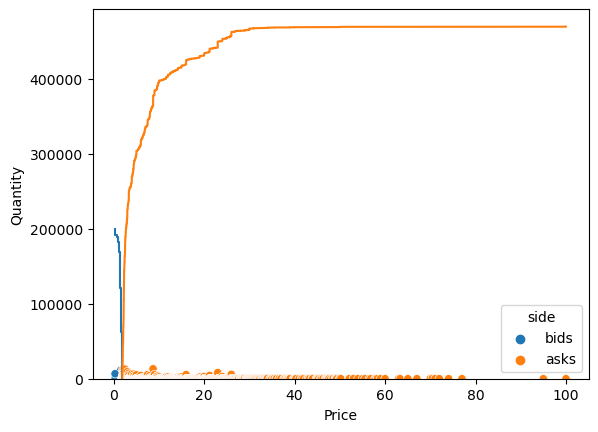

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

frames, data = get_order_book_depth(client, test_symbol)
fig, ax = plt.subplots()
sns.ecdfplot(x='price', weights='quantity', stat='count', complementary=True, data=frames['bids'], ax=ax)
sns.ecdfplot(x='price', weights='quantity', stat='count', data=frames['asks'], ax=ax)
sns.scatterplot(x='price', y='quantity', hue='side', data=data, ax=ax)
ax.set_xlabel('Price')
ax.set_ylabel('Quantity')
plt.show()

#### Screen market.

In [39]:
from cryptocurrency.conversion import get_timezone_offset_in_seconds
from cryptocurrency.conversion_table import get_conversion_table, get_tradable_tickers_info
from time import sleep

def loop_through_tickers(client, threshold=1e6):
    def filter_bid_ask_range_in_loop(symbol):
        sleep(2.9)
        return get_order_book_trigger(client=client, symbol=symbol, threshold=threshold)
    offset_s = get_timezone_offset_in_seconds()
    i = 0
    while True:
        conversion_table = get_conversion_table(client=client, exchange_info=exchange_info, 
                                                offset_s=offset_s, as_pair=True, dump_raw=False, 
                                                minimal=True, extra_minimal=False, 
                                                convert_to_USDT=True)
        tickers_list = get_tradable_tickers_info(conversion_table=conversion_table)[1]
        print('len(tickers_list):', len(tickers_list))
        sleep(5)
        for j, symbol in enumerate(tickers_list):
            if filter_bid_ask_range_in_loop(symbol=symbol):
                print('#{}#{}: {} '.format(str(i), str(j), symbol), end='')
        i += 1

loop_through_tickers(client=client, threshold=1e5)

/home/samuel/workspace/crypto_logger/cryptocurrency/conversion_table.py:238: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  conversion_table_swapped.loc[:, ['symbol', 'price_change_percent', 'close', 'ask_price',
/home/samuel/workspace/crypto_logger/cryptocurrency/conversion_table.py:292: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  conversion_table_swapped.loc[:, ['open', 'close', 'bid_price', 'ask_price', 'USDT_open',
/home/samuel/workspace/crypto_logger/cryptocurrency/conversion_table.py:489: FutureWarning: In a future version, `df.iloc[:, i] = ne

len(tickers_list): 147
#0#25: ATOMUSDT #0#30: MFTUSDT #0#33: AXSUSDT #0#35: FILBUSD #0#51: LINKBUSD #0#56: LINKUSDT #0#60: MTLUSDT #0#63: EOSUSDT #0#65: ETCUSDT #0#70: XRPUSDT #0#75: LUNAUSDT #0#77: XRPBUSD #0#78: XMRUSDT #0#85: WAVESUSDT #0#103: TRXUSDT #0#104: ADAUSDT #0#109: MATICUSDT #0#130: BNBUSDT #0#131: ETHTRY #0#132: FTMUSDT #0#136: DOGEUSDT #0#138: LTCBUSD #0#140: BUSDUSDT #0#141: LTCUSDT 

/home/samuel/workspace/crypto_logger/cryptocurrency/conversion_table.py:238: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  conversion_table_swapped.loc[:, ['symbol', 'price_change_percent', 'close', 'ask_price',
/home/samuel/workspace/crypto_logger/cryptocurrency/conversion_table.py:292: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  conversion_table_swapped.loc[:, ['open', 'close', 'bid_price', 'ask_price', 'USDT_open',
/home/samuel/workspace/crypto_logger/cryptocurrency/conversion_table.py:489: FutureWarning: In a future version, `df.iloc[:, i] = ne

len(tickers_list): 149


KeyboardInterrupt: 